In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from typing import Optional
from torch.utils.data import DataLoader, TensorDataset

In [24]:
class SGD:
    """
    Langevin dynamics approximating SGD on a 1D model
    """
    def __init__(self, lr, q, grad_q, mxx, std_xx, std_xy, w_init, seed):
        """
        lr: learning rate
        q: model
        grad_q: gradient of the model
        mxx: expected value of X^2
        vxx: Var(X^2)
        vxy: Var(XY)
        """
        self.lr = lr
        self.q = q
        self.grad_q = grad_q
        self.mxx = mxx
        self.std_xx = std_xx
        self.std_xy = std_xy
        self.w_init = w_init
        self.w = [self.w_init]
        self.state = np.random.RandomState(seed=seed)


    def update(self, w_old, d1, d2,a=-1,b=1):
        xi_xx = self.state.normal(self.mxx, self.std_xx)
        xi_xy = self.state.normal(0.0, self.std_xy)
        return w_old - self.lr*(xi_xx * self.q(w_old, d1, d2,a,b) - xi_xy) * self.grad_q(w_old, d1, d2,a,b)
    
    def evolve(self, nstep, d1, d2,a=-1,b=1):
        wc = self.w[-1]
        for _ in range(nstep):
            wc = self.update(wc, d1, d2,a,b)
            self.w.append(wc)

class SGD_batch:
    """
    Exact SGD dynamics 
    """
    def __init__(self, lr, q, grad_q, w_init, nsamp, batch_size, seed):
        """
        lr: learning rate
        q: model
        grad_q: gradient of the model
        """
        self.lr = lr
        self.q = q
        self.grad_q = grad_q
        self.nb = batch_size
        self.w = [w_init]
        self.state = np.random.RandomState(seed=seed)
        # uncorrelated X and Y data
        self.x, self.y = self.state.normal(size=(2, nsamp))
        
    def update(self, w_old, d1, d2,a=-1,b=1):
        xb = self.state.choice(self.x, self.nb, replace=False)
        yb = self.state.choice(self.y, self.nb, replace=False)
        
        xi_xx = np.mean(xb*xb)
        xi_xy = np.mean(xb*yb)
        return w_old - self.lr*(xi_xx * self.q(w_old, d1, d2,a,b) - xi_xy) * self.grad_q(w_old, d1, d2,a,b)
    
    def evolve(self, nstep, d1, d2,a=-1,b=1):
        wc = self.w[-1]
        for _ in range(nstep):
            wc = self.update(wc, d1, d2,a,b)
            self.w.append(wc)

def q(w, d1 ,d2, a=-1, b=1):
    return (w - a)**d1 * (w - b)**d2
    
def grad_q(w, d1, d2, a=-1, b=1):
    return (w-a)**(d1-1) * (w - b)**(d2-1) * (d1 * (w -a) + d2*(w - b))




0.6108136111679476


Text(0, 0.5, 'Potential')

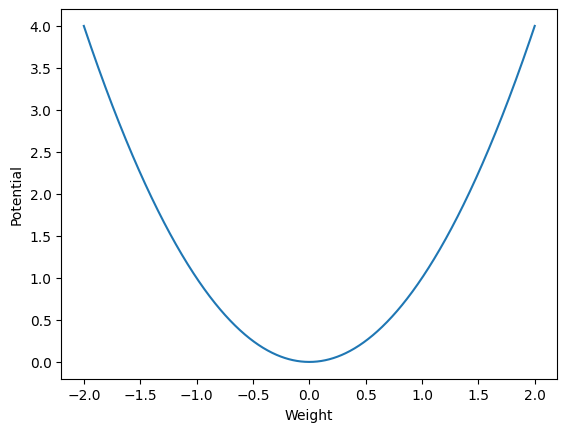

In [25]:
# Run many trajectories of SGD

d1 = 1
d2 = 0
lr = 0.01
batch_size = 20
nsample = 10**4
mxx = 1.
std_xx = 1.
std_xy = 1.
num_trajectories = 1
niterations = 5000

# Change a and b to play with the potential barrier
a=0
b=0.
wmax = 0
wm = 2
trajectories = []

for i in range(num_trajectories):
    seed = i
    w_init = np.random.uniform(-wm,wm)
    print(w_init)
    L = SGD_batch(lr, q, grad_q, w_init, nsample, batch_size, seed)
    L.evolve(niterations, d1, d2,a,b)
    trajectories.append(np.array(L.w).T)

trajectories = np.asarray(trajectories)

# Plot potential

wrange = np.linspace(-wm, wm, 1000)
potential = q(wrange, d1 ,d2, a,b)**2
plt.plot(wrange, potential)
plt.xlabel("Weight")
plt.ylabel("Potential")

In [9]:
# Run many trajectories of SGD

d1 = 1
d2 = 0
lr = 0.001
mxx = 1.
std_xx = 1.
std_xy = 1.
num_trajectories = 10
niterations = 5000

# Change a and b to play with the potential barrier
a=0
b=0.
wmax = 0
wm = 2
trajectories = []

for i in range(num_trajectories):
    seed = i
    w_init = np.random.uniform(-wm,wm)
    L = SGD(lr, q, grad_q, mxx, std_xx, std_xy, w_init, seed)
    L.evolve(niterations, d1, d2,a,b)
    trajectories.append(np.array(L.w).T)

trajectories = np.asarray(trajectories)

# Plot potential

wrange = np.linspace(-wm, wm, 1000)
potential = q(wrange, d1 ,d2, a,b)**2
plt.plot(wrange, potential)
plt.xlabel("Weight")
plt.ylabel("Potential")

-1.9816533583769456


TypeError: SGD_batch.__init__() missing 1 required positional argument: 'seed'

In [30]:
deg = [1, 2, 3]
ndeg = len(deg)
d2 = 0
lr = 0.01
mxx = 1.
std_xx = 1.
std_xy = 1.
num_trajectories = 10
niterations = 10**6

# 
a=0
b=0.
wmax = 0
wm = 0.3
mean_dist = np.zeros((ndeg, niterations+1))
distrib = np.zeros((ndeg, num_trajectories))

for id, d in enumerate(deg):
    dist = 0
    d1 = d
    for i in range(num_trajectories):
        seed = i
        w_init = np.random.uniform(-wm,wm)
        L = SGD(lr, q, grad_q, mxx, std_xx, std_xy, w_init, seed)
        L.evolve(niterations, d1, d2,a,b)
        dist += np.abs(np.array(L.w))/num_trajectories
        distrib[id,i] = np.array(L.w)[-1]
    mean_dist[id,:] = dist # Pb what is the distribution of trajectories?

KeyboardInterrupt: 

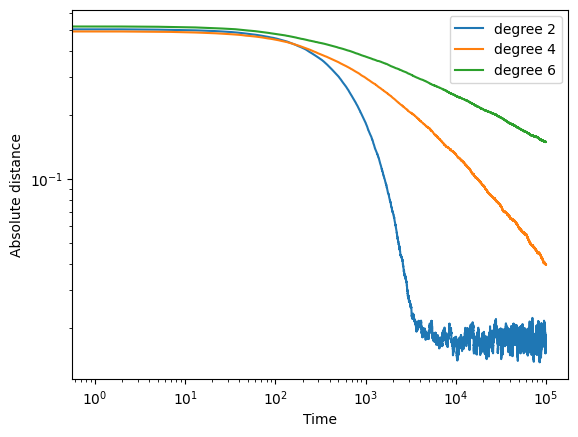

In [27]:
time = np.linspace(0, niterations , niterations+1)
for d in range(ndeg):
    plt.plot(time, mean_dist[d,:], label=f"degree {2*deg[d]}")
    plt.xlabel("Time")
    plt.ylabel("Absolute distance")
    plt.xscale("log")
    plt.yscale("log")
plt.legend()

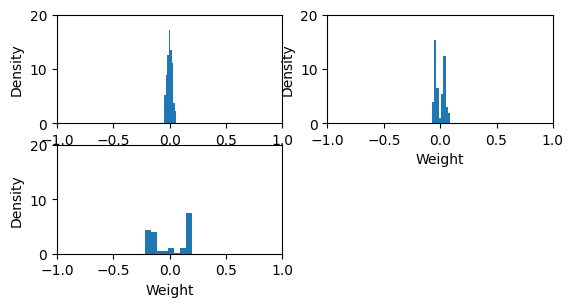

In [28]:
# Look at the "stationary" distribution of trajectories

for id, i in enumerate(deg):
    plt.subplot(3,2,i)
    plt.hist(distrib[id, :], bins="auto", density=True)
    plt.xlabel("Weight")
    plt.ylabel("Density")
    plt.xlim((-wm,wm))
    plt.ylim((0,20))

-1.6118262381331374


Text(0, 0.5, 'Potential')

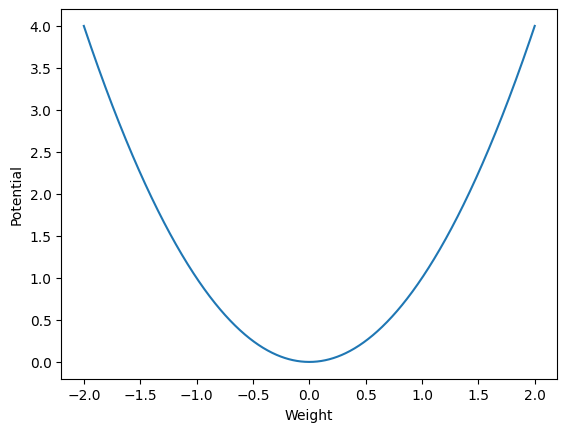

In [17]:
# Comparing with batch sizes

# Run many trajectories of SGD

d1 = 1
d2 = 0
lr = 0.01
batch_size = 20
nsample = 10**4
mxx = 1.
std_xx = 1.
std_xy = 1.
num_trajectories = 1
niterations = 5000

# Change a and b to play with the potential barrier
a=0
b=0.
wmax = 0
wm = 2
trajectories = []

for i in range(num_trajectories):
    seed = i
    w_init = np.random.uniform(-wm,wm)
    L = SGD_batch(lr, q, grad_q, w_init, nsample, batch_size, seed)
    L.evolve(niterations, d1, d2,a,b)
    trajectories.append(np.array(L.w).T)

trajectories = np.asarray(trajectories)

# Plot potential

wrange = np.linspace(-wm, wm, 1000)
potential = q(wrange, d1 ,d2, a,b)**2
plt.plot(wrange, potential)
plt.xlabel("Weight")
plt.ylabel("Potential")


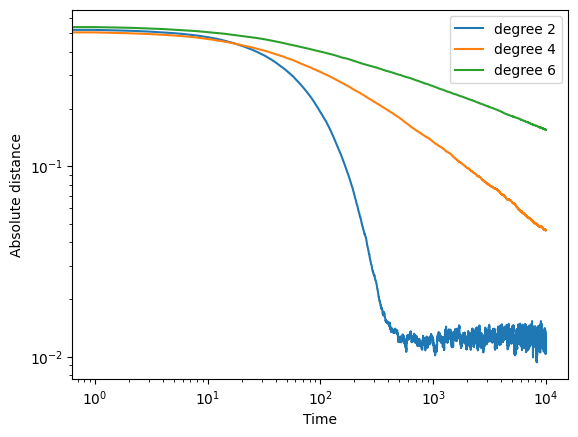

In [20]:
deg = [1, 2, 3]
ndeg = len(deg)
d2 = 0
lr = 0.01
mxx = 1.
std_xx = 1.
std_xy = 1.
num_trajectories = 100
niterations = 10000
nsample = 10**4
batch_size = 20

# 
a=0
b=0.
wmax = 0
wm = 1
mean_dist = np.zeros((ndeg, niterations+1))
distrib = np.zeros((ndeg, num_trajectories))

for id, d in enumerate(deg):
    dist = 0
    d1 = d
    for i in range(num_trajectories):
        seed = i
        w_init = np.random.uniform(-wm,wm)
        L = SGD_batch(lr, q, grad_q, w_init, nsample, batch_size, seed)
        L.evolve(niterations, d1, d2,a,b)
        dist += np.abs(np.array(L.w))/num_trajectories
        distrib[id,i] = np.array(L.w)[-1]
    mean_dist[id,:] = dist # Pb what is the distribution of trajectories?
        
# average distance over many trajectories
# 
# 
time = np.linspace(0, niterations , niterations+1)
for d in range(ndeg):
    plt.plot(time, mean_dist[d,:], label=f"degree {2*deg[d]}")
    plt.xlabel("Time")
    plt.ylabel("Absolute distance")
    plt.xscale("log")
    plt.yscale("log")
plt.legend()

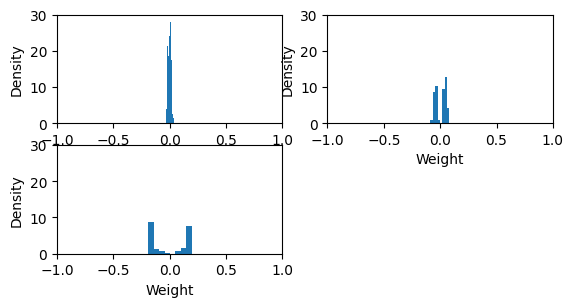

In [23]:
# Look at the "stationary" distribution of trajectories

for id, i in enumerate(deg):
    plt.subplot(3,2,i)
    plt.hist(distrib[id, :], bins="auto", density=True)
    plt.xlabel("Weight")
    plt.ylabel("Density")
    plt.xlim((-wm,wm))
    plt.ylim((0,30))